#### <img src="./../res/logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales 

# Tarea Semanal Nº4
#### Alumno: Mauro Fernández

# 1. Consigna

Simular el comportamiento de un dispositivo ADC al digitalizar una **senoidal contaminada con un nivel predeterminado de ruido**. 

Parámetros a ajustar de la señal senoidal:
* frecuencia $f_0$ arbitraria, por ejemplo $f_0 = f_S/N = \Delta_f$
* **energía normalizada**, es decir, energía (o varianza) unitaria

Parámetros de la secuencia de ruido:

* carácter aditivo, es decir la señal que entra al ADC será $s_R = s + n$. Siendo $n$ la secuencia que simula la interferencia, y $s$ la senoidal descrita anteriormente.
* La potencia del ruido será $P_n = k_n. P_q$ W siendo el factor $k$ una escala para la potencia del ruido de cuantización $P_q = \frac{q^2}{12}$.
* finalmente, $n$ será **incorrelado** y **Gaussiano**.

El ADC que se desea simular trabajará a una frecuencia de muestreo $f_S = 1000$ Hz y tendrá un rango analógico de $±V_F = 2$ Volts.

### Se pide:

a) Generar el siguiente resultado producto de la experimentación. $B = 4$ bits , $k_n = 1$.

<img src="./img/imagen_1.png" align="center"/> 
<img src="./img/imagen_2.png" align="center"/> 
<img src="./img/imagen_3.png" align="center"/> 

b) Analizar para una de las siguientes configuraciones B = {4, 8 y 16} bits, $k_n = \{ 1/10, 1, 10 \}$. Discutir los resultados respecto a lo obtenido en a).

### Ayuda:

Se da un script de referencia para que lo completes con la generación de los gráficos que se ven en esta tarea: https://pastebin.com/AGMrGYbc

### Bonus:

* Encontrar la relación entre la cantidad de B bits del ADC y el SNR de la señal digitalizada. (Ver [Holton. DSP Principles and App](https://drive.google.com/file/d/1af1DNdtUrxF1MtQqX9a7CZt-nkkVrRqs/view?usp=sharing). 6.7 ADC Quantization pag. 387)
* Simular el efecto del *aliasing* junto con el muestreo.

# 2. Resolución

En la siguiente sección se implementa en una función el script de referencia completo con las generaciones de las señales intermedias. La función recibe como parámetros B y $k_n$, lo que permite generar con facilidad los resultados requeridos para las diferentes configuraciones.

## 2.1. Simulador ADC

In [89]:
import numpy as np

def mi_simulador_adc(B,kn):
    """ Simula el comportamiento de un ADC para una señal senoidal.
    
    Args:
        B  (int): cantidad de Bits ADC para cuantización
        kn (int): factor de escala para la potencia del ruido de cuantización

    Returns:
        void
    """
    #######################################################################################################################
    #%% Configuración e inicio de la simulación
    #######################################################################################################################

    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.signal as sig

    import matplotlib as mpl
    
    # Configuración del tamaño de los gráficos
    mpl.rcParams['figure.figsize'] = (15,7)

    # Datos generales de la simulación
    fs = 1000.0 # frecuencia de muestreo (Hz)
    N  = 1000   # cantidad de muestras

    # cantidad de veces más densa que se supone la grilla temporal para tiempo "continuo"
    over_sampling = 4
    N_os = N*over_sampling

    # Datos del ADC
    #B  = 4 # bits
    Vf = 2 # Volts
    q  = Vf/2**B # Volts

    # datos del ruido
    #kn = 1
    pot_ruido = q**2/12 * kn # Watts (potencia de la señal 1 W)

    ts = 1/fs # tiempo de muestreo
    df = fs/N # resolución espectral

    #######################################################################################################################
    #%% Acá arranca la simulación

    # Importamos herramientas anteriormente implementadas de biblioteca PDS
    from pds import mi_funcion_sen, mi_cuantizador

    # Frecuencia de muestreo oversampling
    fs_os = fs * over_sampling

    # Frecuencia de la señal senoidal "analógica" sampleada
    f0 = fs / N

    # Generamos grilla de frecuencias
    ff = np.linspace(0,(N-1)*df,N)

    # Generamos grilla de frecuencias (sobremuestreada)
    ff_os = np.linspace(0,(N-1)*df,N_os)

    # Definimos potencia de la señal senoidal como unitaria
    pot_sen = 1

    # Calculamos amplitud a partir de la potencia de una senoidal: P = (A^2)/2
    amp_sen = np.sqrt(2*pot_sen)

    # Generamos señal senoidal "analógica"
    tt_os, analog_sig = mi_funcion_sen(amp_sen, 0, f0, 0, N_os, fs_os)

    # Definimos valor medio y desvío estandard del ruido
    # El desvío standard es la raiz de la varianza del ruido y la varianza es la potencia del mismo
    noise_mean = 0
    noise_var  = pot_ruido
    noise_std  = np.sqrt(noise_var)

    # Generamos ruido gaussiano
    noise = np.random.normal(noise_mean,noise_std,analog_sig.size)

    # Generamos señal senoidal "analógica" ruidosa
    sr = analog_sig + noise

    # Muestreamos la señal senoidal "analógica" ruidosa
    sr = sr[::over_sampling]
    tt = tt_os[::over_sampling]

    # Generamos señal cuantizada
    srq = mi_cuantizador(sr,B,Vf)

    # Calculamos el ruido de cuantización
    nq = srq - sr

    # Calculamos la FFT del ruido
    ft_Nn = np.fft.fft(noise, axis=0)/N_os

    # Calculamos la FFT de la señal analógica
    ft_As = np.fft.fft(analog_sig, axis=0)/N_os

    # Calculamos la FFT de la señal analógica ruidosa muestreada y cuantizada
    ft_Srq = np.fft.fft(srq, axis=0)/N

    # Calculamos la FFT de la señal analógica ruidosa muestreada
    ft_SR = np.fft.fft(sr, axis=0)/N

    # Calculamos la FFT del ruido de cuantización
    ft_Nq = np.fft.fft(nq, axis=0)/N

    # Calculamos el valor medio del ruido
    nNn_mean = np.mean(np.abs(ft_Nn)**2)

    #######################################################################################################################
    #%% Presentación gráfica de los resultados
    plt.close('all')

    plt.figure(1)
    plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
    plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
    plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')

    plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
    plt.xlabel('tiempo [segundos]')
    plt.ylabel('Amplitud [V]')
    axes_hdl = plt.gca()
    axes_hdl.legend()
    plt.show()


    plt.figure(2)
    bfrec = ff <= fs/2

    Nnq_mean = np.mean(np.abs(ft_Nq)**2)

    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
    plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
    plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
    plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
    plt.ylabel('Densidad de Potencia [dB]')
    plt.xlabel('Frecuencia [Hz]')
    axes_hdl = plt.gca()
    axes_hdl.legend()
    # suponiendo valores negativos de potencia ruido en dB
    plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))


    plt.figure(3)
    bins = 10
    plt.hist(nq, bins=bins)
    plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
    plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))

# 3. Implementación
En la siguiente sección se hace uso del simulador ADC con diferentes configuraciones para el punto a) y b)


## 3.1. Configuración: B = 4 bits y $K_n$ = 1

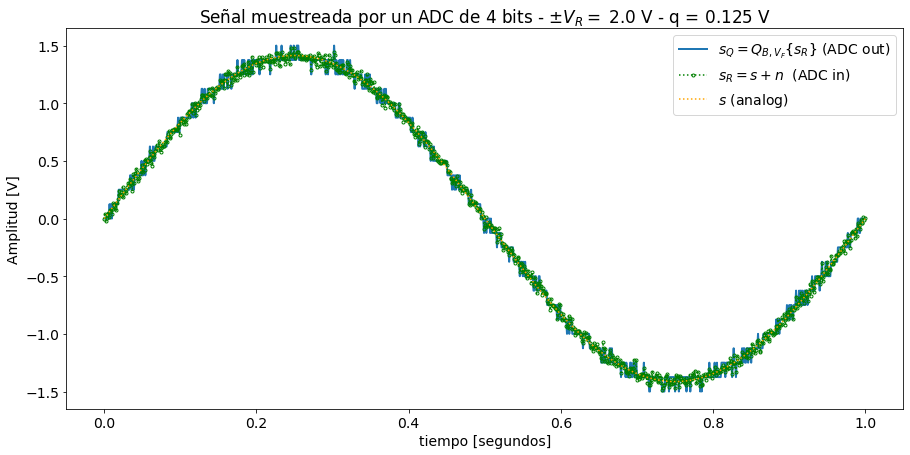

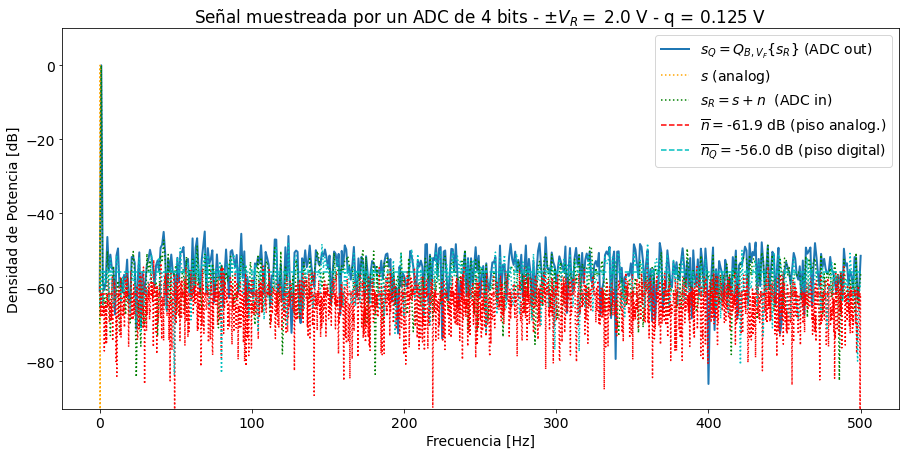

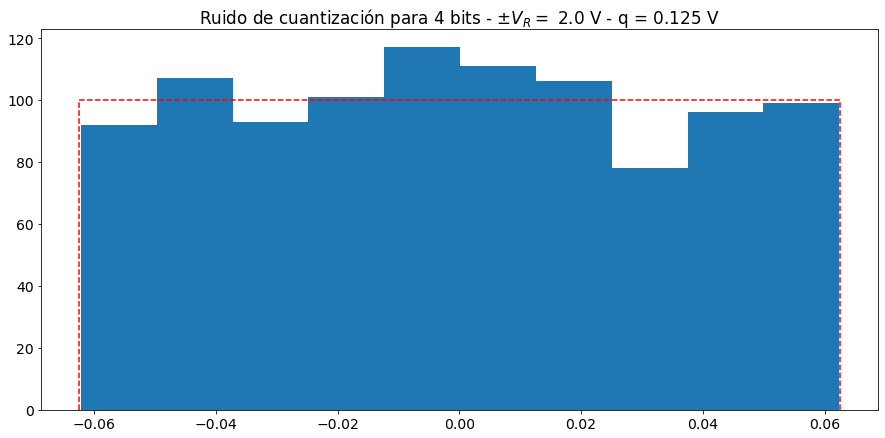

In [90]:
mi_simulador_adc(B = 4, kn = 1)

## 3.2. Configuración: B = 4 bits y $K_n$ = 1/10

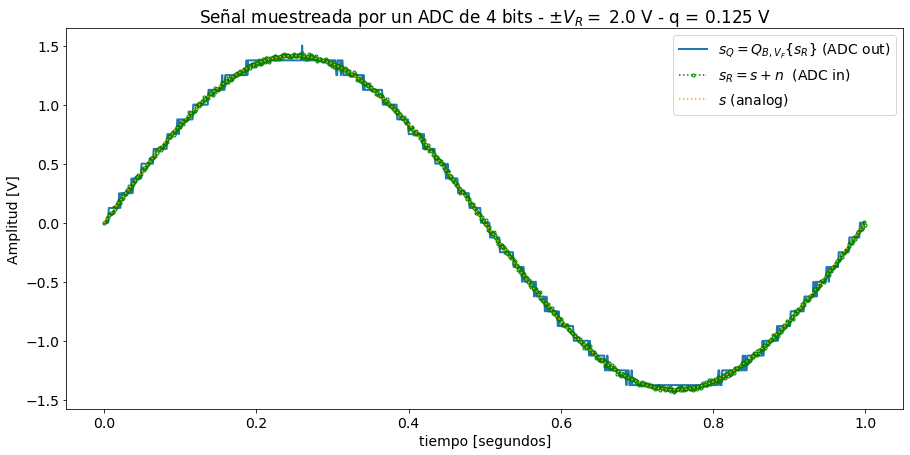

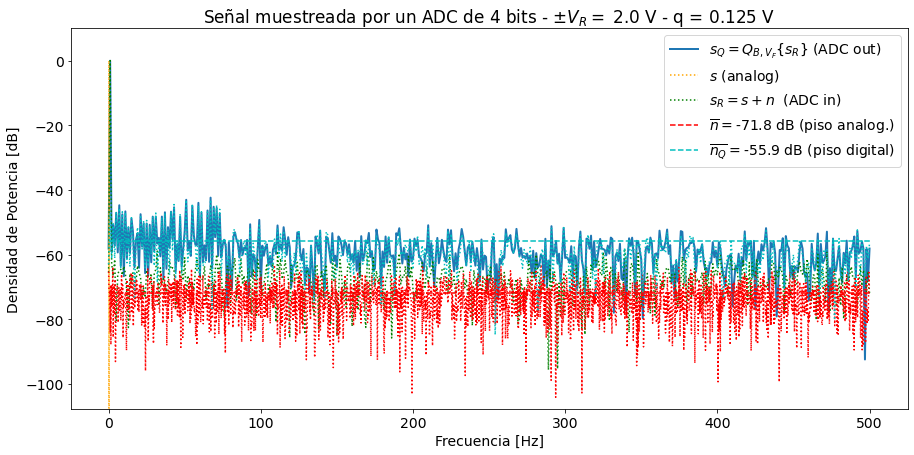

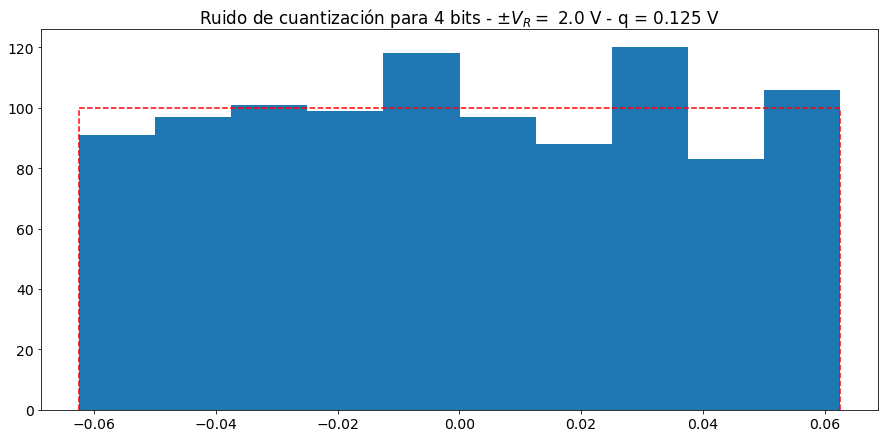

In [91]:
mi_simulador_adc(B = 4, kn = 1/10)

## 3.3. Configuración: B = 4 bits y $K_n$ = 10

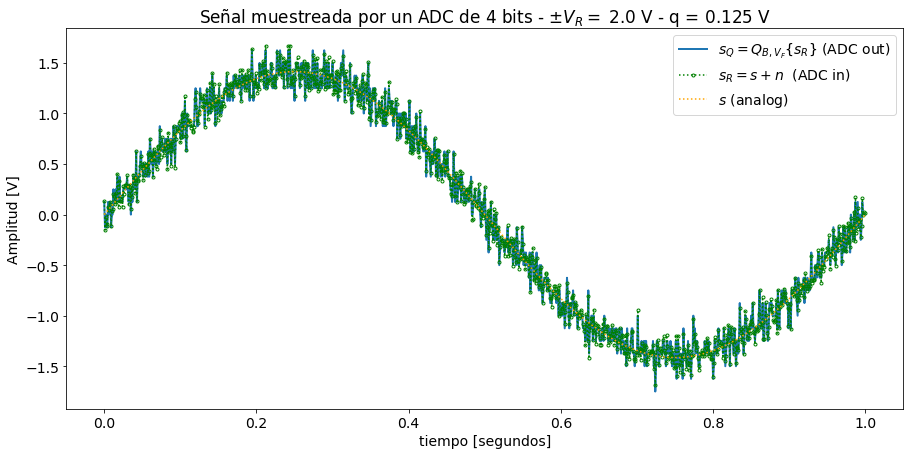

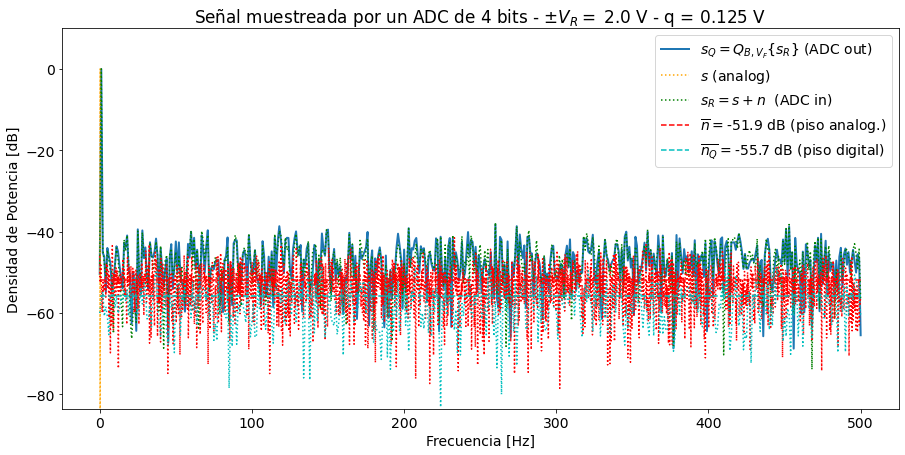

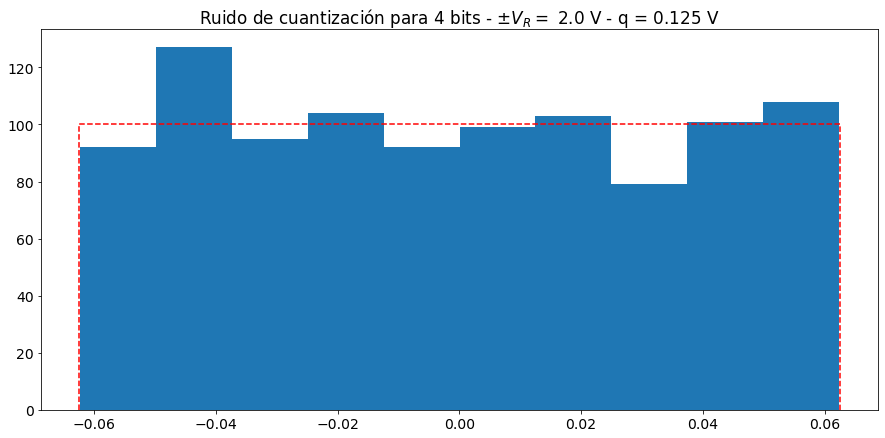

In [92]:
mi_simulador_adc(B = 4, kn = 10)

## 3.4. Configuración: B = 8 bits y $K_n$ = 1

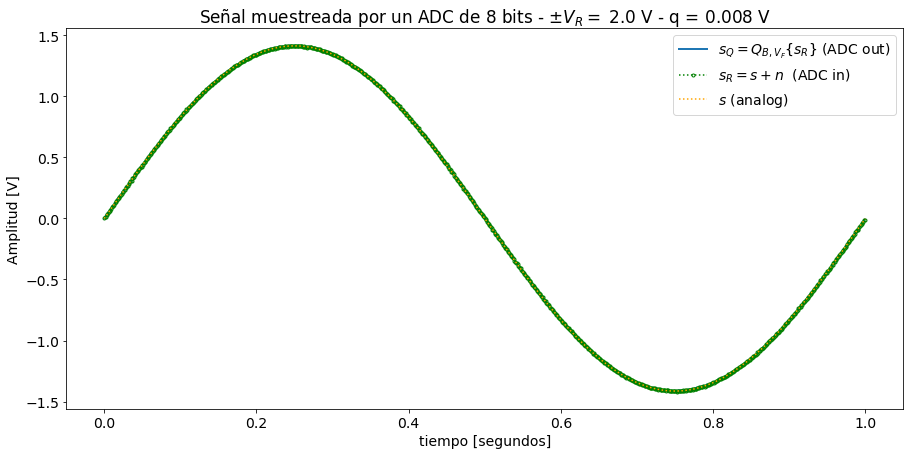

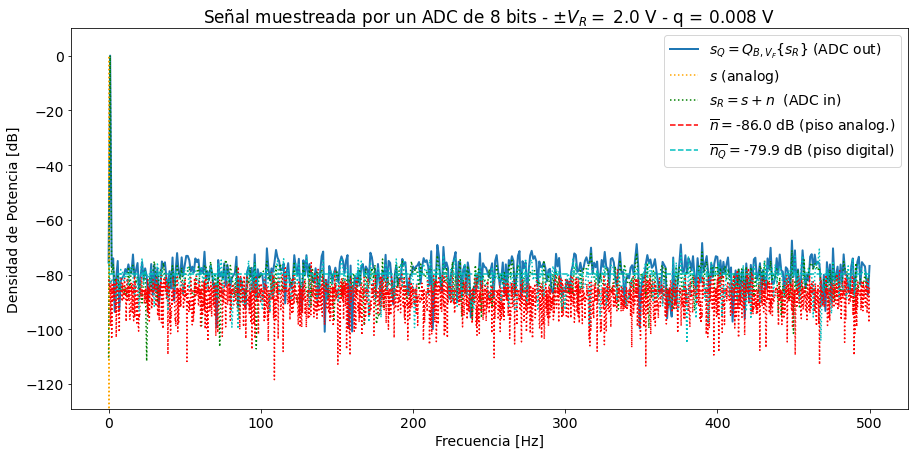

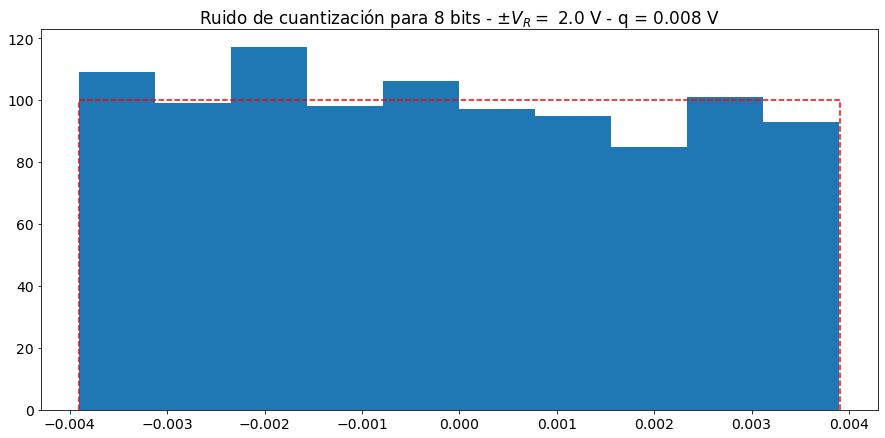

In [93]:
mi_simulador_adc(B = 8, kn = 1)

## 3.5. Configuración: B = 16 bits y $K_n$ = 1

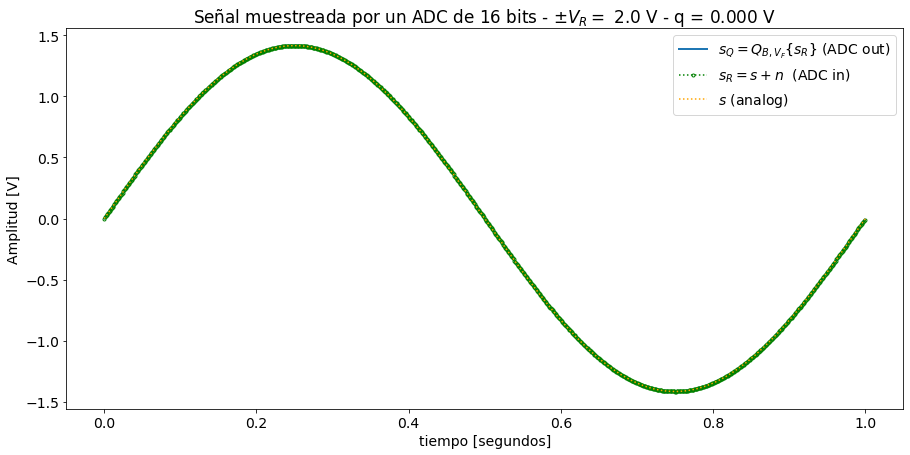

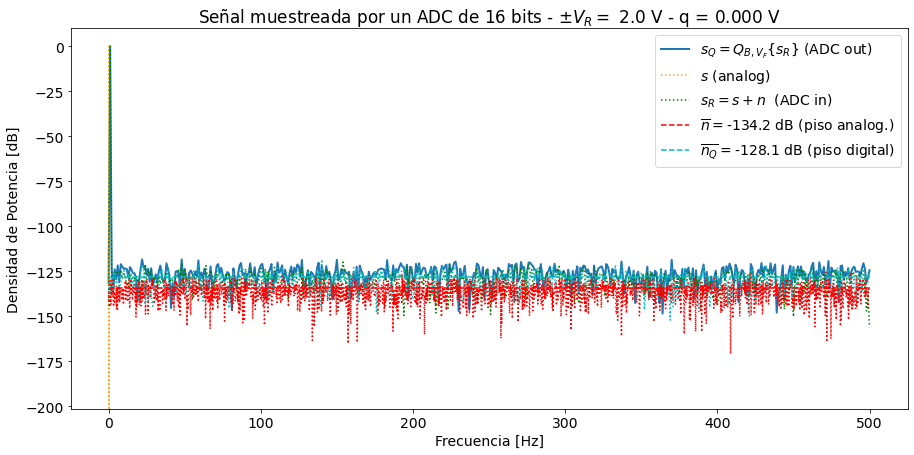

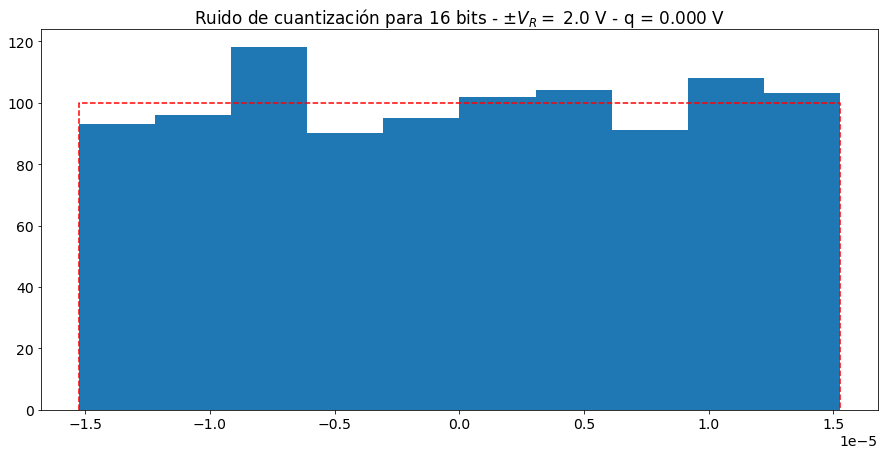

In [94]:
mi_simulador_adc(B = 16, kn = 1)

# 4. BONUS
## 4.1. Relación entre la cantidad de B bits del ADC y el SNR de la señal digitalizada

El SNR (Signal-to-quantization-noise ratio) nos permite conocer la proporción entre la potencia de una señal y la potencia del ruido que la corrompe.
Podemos entonces a partir del SNR conocer la proporción entre la potencia de una señal y la potencia del ruido de cuantización.

A continuación se presenta la ecuación que relaciona la cantidad de B bits del ADC y el SNR de la señal:
<br> 
<br>
<center> $\Large SNR \overset{\Delta}{=} 10 \ log_{10} \frac{\sigma_x ^2}{\sigma_e ^2} = 10 \ log_{10} \frac{12 \ . \ 2^{2B} \sigma_x ^2}{V^2_{FS}} = 6.02B + 10.79 + 20 \ log_{10} \frac{\sigma_x}{V_{FS}} $ </center>

Como puede observarse, el SNR depende de 3 cantidades:
1. la resolución del conversor: $B$
2. el nivel RMS de la señal, que es el desvío standard: $\sigma_x$
3. el máximo rango del conversor: $V_{FS}$

## 4.2. Simulación del efecto de aliasing junto con el muestreo.

En esta revisión del notebook aún no se simuló el efecto de aliasing con el muestreo

# 5. Conclusiones
* Nuestra referencia analógica generada con el sistema de numeración de doble precisión se encuentra en -350 dB (en el gráfico no se ve porque está limitado en el rango de interés). Es el caso ideal.
* Al cuantizar empeoramos la precisión dado que dividimos la amplitud de la señal senoidal por $q$, luego redondeamos y volvimos a multiplicar por $q$. Por eso el piso de ruido de la señal senoidal cuantizada subió hasta aprox -60 dB.
* Cuando aumentamos la cantidad de bits del conversor, el piso del ruido de cuantización baja en dB (mejora precisión). Caso contrario, sube (empeora precisión). 
* Dado que la potencia del ruido que añadimos a la señal es proporcional a la potencia del ruido de cuantización, el piso del ruido añadido a la señal también baja en dB al incrementar la cantidad de bits del conversor y caso contrario sube. En ambos casos, la distancia entre los pisos permanece constante dado que no se ha afectado la constante de proporcionalidad.
* Si $K_n$ > 1, el piso de ruido añadido queda por encima del piso de ruido de cuantización en dB, lo que significa que este ruido es el que domina. Caso contrario, si 0 < $K_n$ < 1 el piso de ruido añadido queda por debajo del piso de ruido de cuantización en dB, es decir el que domina es el ruido de cuantización. 